# Final Report: Classifying Pulsars
Authors: Rico, Iqbal, Kimmy, Hank, Haonan, Bhavya

## Introduction
Question: To determine whether the signal is coming from a pulsar star or not based on the integrated profile of the signal?

A pulsar is a Neutron star that generates pulses of solar radio emissions (i.e. emits wavelengths of light in periodic bursts) detectable from Earth. The light is generally very bright and can be seen from a distance. Pulsar stars are studied to help scientists study gravitational waves, which could help in studying potential cosmic events such as collisions (Cofield, 2016). 
 
Each potential detection (which we’ll call a candidate) is represented numerically by two curves:  the integrated profile and DM-SNR. Since a pulsar periodically emits unique pulses, the integrated profile is used to represent an average of these different pulses (Lorimer and Kramer, 2005; Lyon, 2016). To describe the uncertainty caused by dispersion (where each pulse is detected at different times across frequencies), a dispersion- measure-signal-to-noise (DM-SNR) curve is used (Lyon, 2016). Furthermore, each curve is described by four statistical variables: mean, standard deviation, kurtosis, and skewness.
 
In reality, most candidates are spurious and caused by radio frequency interference and noise, consequently making positive pulsar cases rare to detect. Hence, our goal for this project is to train a model that classifies whether a star is non-pulsar or pulsar star based on 8 variables: the mean, standard deviation, kurtosis, and skewness of the integrated profile and DM-SNR curve. Our central question is: To determine whether the signal is coming from a pulsar star or not based on the integrated profile of the signal?
 
Our dataset is a sample of candidate detections recorded by the High time Resolution Universe Survey. The data set contains 17,898 total observations, with 1639 observations being positive pulsar detections. The dataset also contains 8 variables: the mean, standard deviation, kurtosis, and skewness of the integrated profile and DM-SNR curve.

References:
Cofield, C. (2016, April 22). What Are Pulsars? Space.com; Space. https://www.space.com/32661-pulsars.html 
Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., &amp; Knowles, J. D. (2016). Fifty Years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656 
Lorimer, D. R., &amp; Kramer, M. (n.d.). Handbook of Pulsar Astronomy. NASA/ADS. Retrieved March 5, 2022, from https://ui.adsabs.harvard.edu/abs/2012hpa..book.....L/abstract 

## Methods and Results

In [1]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('gridExtra')
install.packages('themis')

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘hardhat’, ‘ipred’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Import packages
library(tidyverse)
library(tidymodels)
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune      0.1.1
✔ modeldata 0.0.2     ✔ workflows 0.2.0
✔ parsnip   0.1.3     ✔ yards

In [102]:
# Read csv file 
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('https://raw.githubusercontent.com/iaujla01/DSCI100Project/main/data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### Splitting Our Dataset

In [103]:
# Picked seed 3456 for reproducible results
set.seed(3456)

# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decided to split dataset into 75% training and 25% testing
 recipe_upsample <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_data) %>%
                     step_upsample(class, over_ratio = 1, skip = FALSE)

 htru_upscaled <- recipe_upsample %>%
                 prep() %>%
                 bake(htru_data)
 group_by(htru_upscaled, class) %>%
 summarize(n = n())
htru_split <- initial_split(htru_upscaled, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,16259
1,16259


Rows: 24,390
Columns: 5
$ mean_ip     <dbl> 140.56250, 103.01562, 136.75000, 88.72656, 93.57031, 130.…
$ sd_ip       <dbl> 55.68378, 39.34165, 57.17845, 40.67223, 46.69811, 39.8440…
$ kurtosis_ip <dbl> -0.23457141, 0.32332837, -0.06841464, 0.60086608, 0.53190…
$ skew_ip     <dbl> -0.69964840, 1.05116443, -0.63623837, 1.12349169, 0.41672…
$ class       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Rows: 8,128
Columns: 5
$ mean_ip     <dbl> 102.50781, 119.48438, 107.25781, 95.86719, 106.64844, 119…
$ sd_ip       <dbl> 58.88243, 48.76506, 39.49649, 42.05992, 56.36718, 52.8748…
$ kurtosis_ip <dbl> 0.465318154, 0.031460220, 0.465881961, 0.326386917, 0.378…
$ skew_ip     <dbl> -0.5150879, -0.1121676, 1.1628771, 0.8035018, -0.2663716,…
$ class       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


### Preliminary Summary

In [105]:
positive_candidates <- htru_train %>% 
    group_by(class) %>% 
    summarize(n = n())
positive_candidates

htru_proportions <- htru_train %>%
    group_by(class) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(htru_train))
htru_proportions

# Looking at figure xxx, we can see that there are 1226 positive pulsar candidates in the training data 

mean_htru_train<- htru_train %>% 
    group_by(class) %>% 
    summarize(max_mean_ip = max(mean_ip, na.rm = TRUE),
             max_sd_ip = max(sd_ip, na.rm = TRUE),
             max_kurtosis_ip = max(kurtosis_ip, na.rm = TRUE),
             max_skew_ip = max(skew_ip, na.rm = TRUE),
             max_mean_dmsnr = max(mean_dmsnr, na.rm = TRUE),
             max_sd_dmsnr = max(sd_dmsnr, na.rm = TRUE),
             max_kurtosis_dmsnr = max(kurtosis_dmsnr, na.rm = TRUE),
             max_skew_dmsnr = max(skew_dmsnr, na.rm = TRUE),
             min_mean_ip = min(mean_ip, na.rm = TRUE),
             min_sd_ip = min(sd_ip, na.rm = TRUE),
             min_kurtosis_ip = min(kurtosis_ip, na.rm = TRUE),
             min_skew_ip = min(skew_ip, na.rm = TRUE),
             min_mean_dmsnr = min(mean_dmsnr, na.rm = TRUE),
             min_sd_dmsnr = min(sd_dmsnr, na.rm = TRUE),
             min_kurtosis_dmsnr = min(kurtosis_dmsnr, na.rm = TRUE),
             min_skew_dmsnr = min(skew_dmsnr, na.rm = TRUE))%>%
             pivot_longer(cols = -class,
                 names_to = 'variable_max_min',
                 values_to = 'Value') 
mean_htru_train
# At the beginning of the study, it was reasonable to consider that the critical points (extremes) of these data 
# could be correlated with whether or not they were judged to be pulsars

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12195
1,12195


`summarise()` ungrouping output (override with `.groups` argument)



class,n,percent
<fct>,<int>,<dbl>
0,12195,50
1,12195,50


ERROR: Error: Problem with `summarise()` input `max_mean_dmsnr`.
[31m✖[39m object 'mean_dmsnr' not found
[34mℹ[39m Input `max_mean_dmsnr` is `max(mean_dmsnr, na.rm = TRUE)`.
[34mℹ[39m The error occurred in group 1: class = "0".


### Preliminary Visualization

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



ERROR: Error in FUN(X[[i]], ...): object 'mean_dmsnr' not found


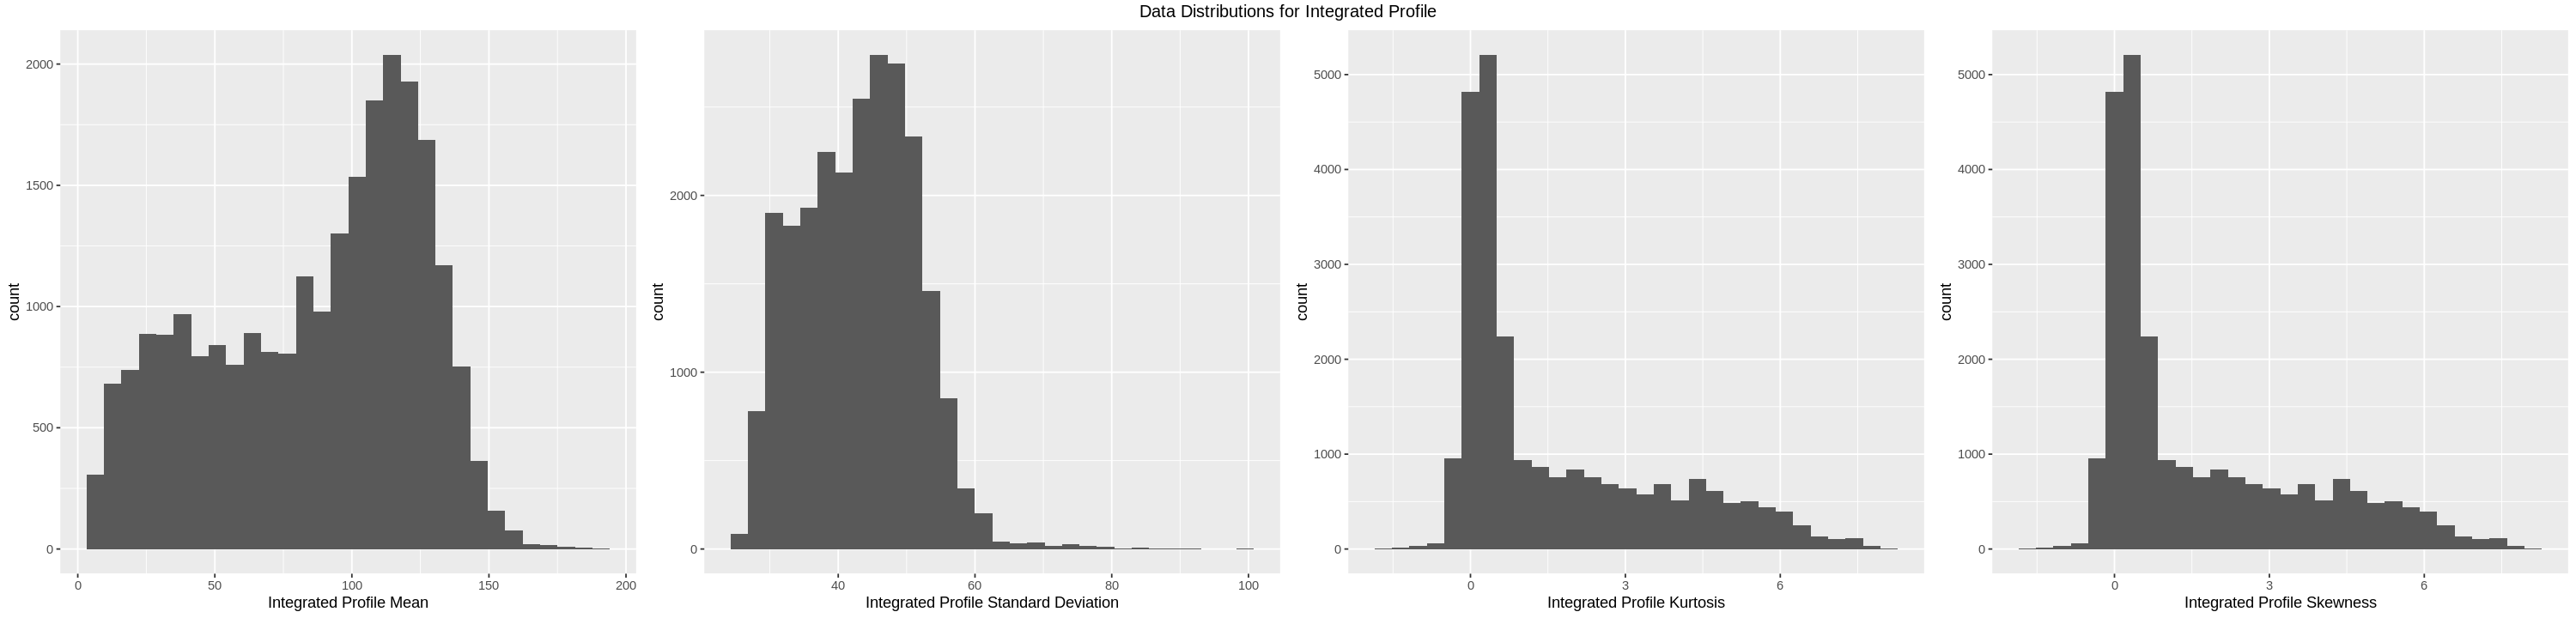

In [106]:
library(gridExtra) # package used to arrange plots neatly in a grid
options(repr.plot.width = 25, repr.plot.height = 6)

vis_mean_ip <- ggplot(htru_train, aes(x = mean_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Mean')
vis_sd_ip <- ggplot(htru_train, aes(x = sd_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Standard Deviation')
vis_kurtosis_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Kurtosis')
vis_skew_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Skewness')
vis_mean_dmsnr <- ggplot(htru_train, aes(x = mean_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Mean')
vis_sd_dmsnr <- ggplot(htru_train, aes(x = sd_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Standard Deviation')
vis_kurtosis_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Kurtosis')
vis_skew_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DMSNR Skewness')

grid.arrange(vis_mean_ip, vis_sd_ip, vis_kurtosis_ip, vis_skew_ip, nrow = 1, top = 'Data Distributions for Integrated Profile')
grid.arrange(vis_mean_dmsnr, vis_sd_dmsnr, vis_kurtosis_dmsnr, vis_skew_dmsnr, nrow = 1, top = 'Data Distributions for DM-SNR')

### Building and Training Our Classifier Model

In [107]:
# set.seed(3456)
# recipe_upsample <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_data) %>%
#                     step_upsample(class, over_ratio = 1, skip = FALSE)

# htru_train2 <- recipe_upsample %>%
#                 prep() %>%
#                 bake(htru_train)
# group_by(htru_train2, class) %>%
# summarize(n = n())

In [108]:
set.seed(3456)  
 
# Setting up tuning model
htru_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                              set_engine("kknn") %>%
                              set_mode("classification")

# Creating preprocessing recipe
htru_recipe <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_train) %>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors()) 

In [109]:
set.seed(3456)  

# Performing cross-validation 
htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)
# Have tried more folds, but no statically significant results 
gridvals <- tibble(neighbors = 1:14) # Picked 14 neighbors to test (inadequate computer power to test more)

htru_results <- workflow() %>%
                add_recipe(htru_recipe) %>%
                add_model(htru_tune) %>%
                tune_grid(resamples = htru_vfold, grid = gridvals) %>%
                collect_metrics() %>% 
                filter(.metric == "accuracy")
htru_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9865519,5,0.0006848419,Model01
2,accuracy,binary,0.9865519,5,0.0006848419,Model02
3,accuracy,binary,0.9760148,5,0.0009980042,Model03
4,accuracy,binary,0.9760148,5,0.0009980042,Model04
5,accuracy,binary,0.9662977,5,0.0006909512,Model05
6,accuracy,binary,0.9662977,5,0.0006909512,Model06
7,accuracy,binary,0.9578926,5,0.0009496708,Model07
8,accuracy,binary,0.9578926,5,0.0009496708,Model08
9,accuracy,binary,0.9496515,5,0.0014705950,Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9865519,5,0.0006848419,Model01


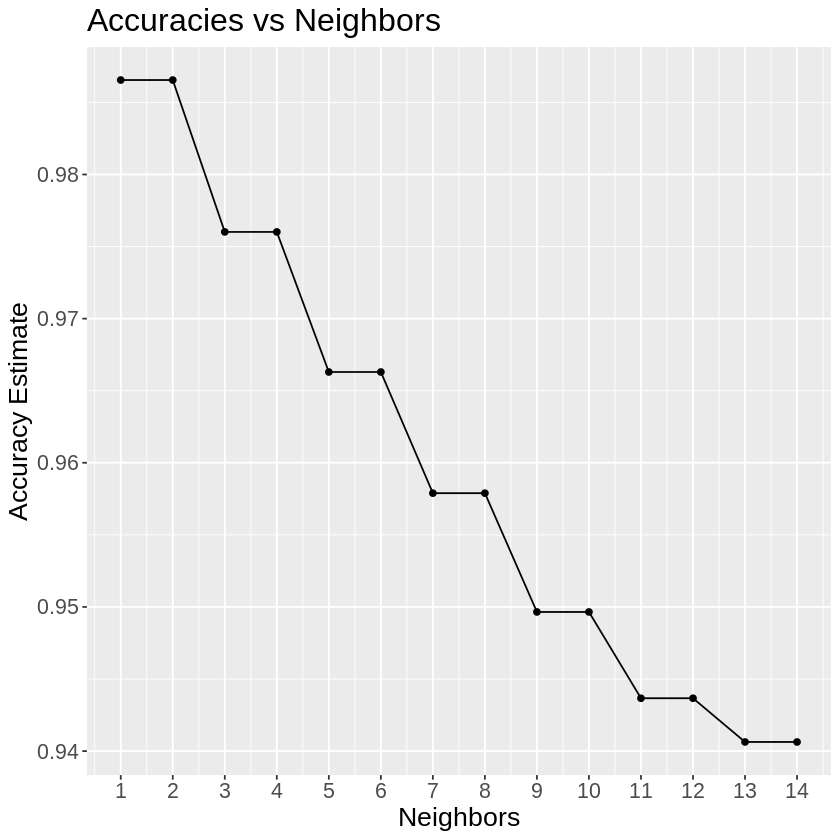

In [110]:
set.seed(3456)  

options(repr.plot.width = 7, repr.plot.height = 7)

# Finding the number of neighbors that yields the highest accuracy (mean)
k_max <- htru_results %>%
    arrange(desc(mean)) %>% 
    slice(1)
k_max

# Plotting accuracy against neighbors
accuracies_vs_k  <- ggplot(htru_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle('Accuracies vs Neighbors') +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, 1)) + 
       theme(text = element_text(size = 16))
accuracies_vs_k 

In [111]:
set.seed(3456)  

k_best <- k_max %>% 
    pull(neighbors)

# Specifying model using best number of neighbors
htru_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# Fitting our model to the training data
htru_fit <- workflow() %>%
  add_recipe(htru_recipe) %>%
  add_model(htru_spec) %>%
  fit(data = htru_train)

# Evaluating our model with the testing data
htru_predictions <- htru_fit %>%
  predict(htru_test) %>%
  bind_cols(htru_test) %>%
  metrics(truth = class, estimate = .pred_class) %>%
  filter(.metric == 'accuracy')
htru_predictions

htru_matrix <- htru_fit %>% 
    predict(htru_test) %>% 
    bind_cols(htru_test) %>%
    conf_mat(truth = class, estimate = .pred_class)
htru_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9875738


          Truth
Prediction    0    1
         0 3963    0
         1  101 4064

## Discussion

## References